In [30]:
import pyterrier as pt
import pandas as pd
import numpy as np
from pyterrier.measures import RR, nDCG, MAP

import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

# from nlpaug.util import Action
from common_helpers import *

In [31]:
dataset_path = "irds:beir/fiqa"
dataset = pt.get_dataset(dataset_path)
testset = pt.get_dataset(dataset_path + "/test")
test_queries = testset.get_topics()

In [32]:
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
    fields=["text"]
)
index_ref = indexer.index(dataset.get_corpus_iter())

beir/fiqa documents:   0%|          | 0/57638 [00:00<?, ?it/s]

beir/fiqa documents: 100%|██████████| 57638/57638 [01:21<00:00, 703.88it/s] 


In [33]:
bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

models = [bm25]
metrics = [RR @ 10, nDCG @ 10, MAP @ 100]
noise_levels = np.arange(0.0, 0.5, 0.1)

cer = np.arange(0.0, 0.5, 0.05)
wer_b_1 = np.arange(0.0, 0.5, 0.05)
wer_b_2 = np.arange(0.0, 1, 0.1)


noise_combinations = [
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    # {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    # {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    # {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

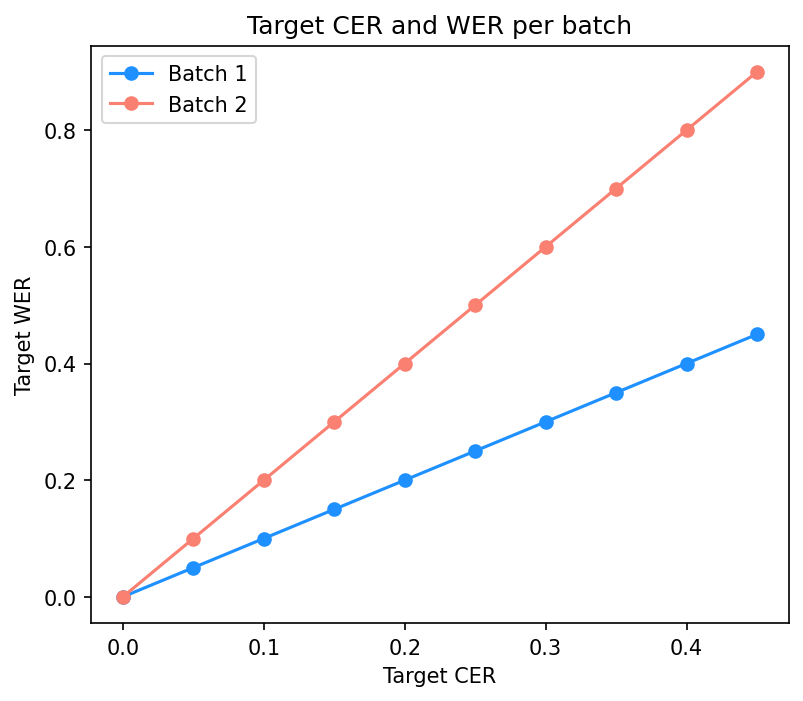

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Plot
plt.figure(figsize=(6, 5), dpi=150)
plt.plot(cer, wer_b_1, 'o-', label="Batch 1", color="dodgerblue")
plt.plot(cer, wer_b_2, 'o-', label="Batch 2", color="salmon")
# plt.plot(cer_values, wer_values, 'o-', label="Batch 3", color="mediumseagreen")

# Labels and title
plt.xlabel("Target CER")
plt.ylabel("Target WER")
plt.title("Target CER and WER per batch")
plt.legend()

# Remove grid
plt.grid(False)

# Show plot
plt.show()


In [35]:
import Levenshtein

def calc_cer(reference: str, hypothesis: str) -> float:
    """
    Compute the Character Error Rate (CER) between a reference sentence and a hypothesis.
    
    Parameters:
        reference (str): The ground truth sentence.
        hypothesis (str): The predicted sentence.

    Returns:
        float: CER value (lower is better).
    """
    distance = Levenshtein.distance(reference, hypothesis)
    return distance / max(1, len(reference))  # Avoid division by zero

# Example usage
ref = "hello world"
hyp = "helo wrld"
print(f"CER: {calc_cer(ref, hyp):.4f}")


CER: 0.1818


In [36]:
from tqdm import tqdm

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
tfidf = pt.terrier.Retriever(index_ref, wmodel="TF_IDF")

# Run Experiment
retrievers = {
    "TF-IDF": tfidf,
    "BM25": bm25,
}

results_batch_1 = []
results_batch_2 = []

 
for noise_config in tqdm(noise_combinations):
    
    sub_prob = noise_config["sub"]
    ins_prob = noise_config["ins"]
    del_prob = noise_config["del"]

    results_for_augmentor = []

    for model_name, retriever in retrievers.items():

        results_for_model = []

        for index in range(len(cer)):

            aug = naf.Sequential([
                nac.RandomCharAug(action="substitute", aug_word_p=wer_b_1[index], aug_char_p=(sub_prob * cer[index]), spec_char=""),
                nac.RandomCharAug(action="insert", aug_word_p=wer_b_1[index], aug_char_p=(ins_prob * cer[index]), spec_char=""),
                nac.RandomCharAug(action="delete", aug_word_p=wer_b_1[index], aug_char_p=(del_prob * cer[index]), spec_char="")
            ])

            noisy_queries_list = []

            actual_cer = 0.0


            for _, row in test_queries.iterrows():
                noisy_query = aug.augment(row['query'])
                noisy_query = " ".join(noisy_query) if isinstance(noisy_query, list) else noisy_query
                noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

                actual_cer += calc_cer(row['query'], noisy_query)

                

            noisy_queries_df = pd.DataFrame(noisy_queries_list)
            noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

            actual_cer = actual_cer / len(test_queries)


            eval_result = pt.Experiment(
                [retriever],
                noisy_queries_df,
                testset.get_qrels(),
                eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
            )

            results_for_model.append({
                "noise_level": actual_cer,
                "results": eval_result
            })

        results_for_augmentor.append({
            "model_name": model_name,
            "results": results_for_model
        })

    results_batch_1.append({
        "noise_config": noise_config,
        "results": results_for_augmentor
    })



  0%|          | 0/4 [00:00<?, ?it/s]

21:26:55.468 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
21:30:08.734 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


100%|██████████| 4/4 [25:50<00:00, 387.55s/it]


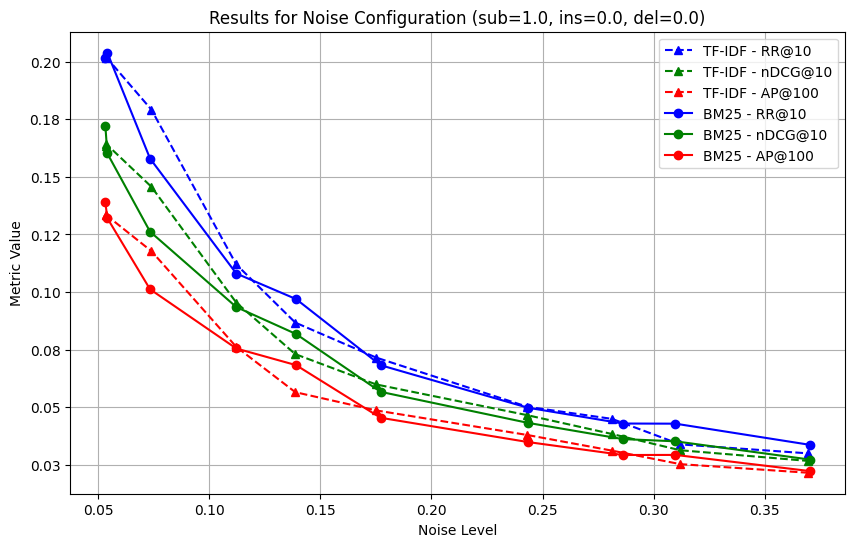

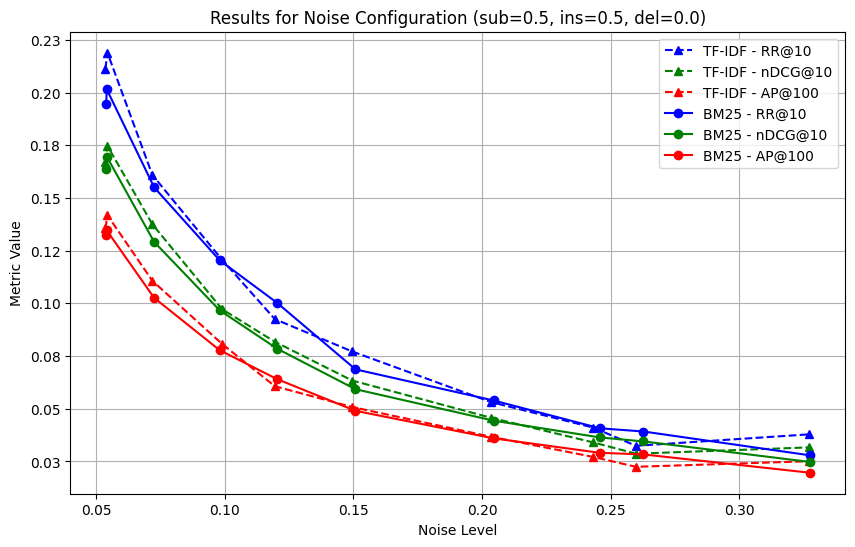

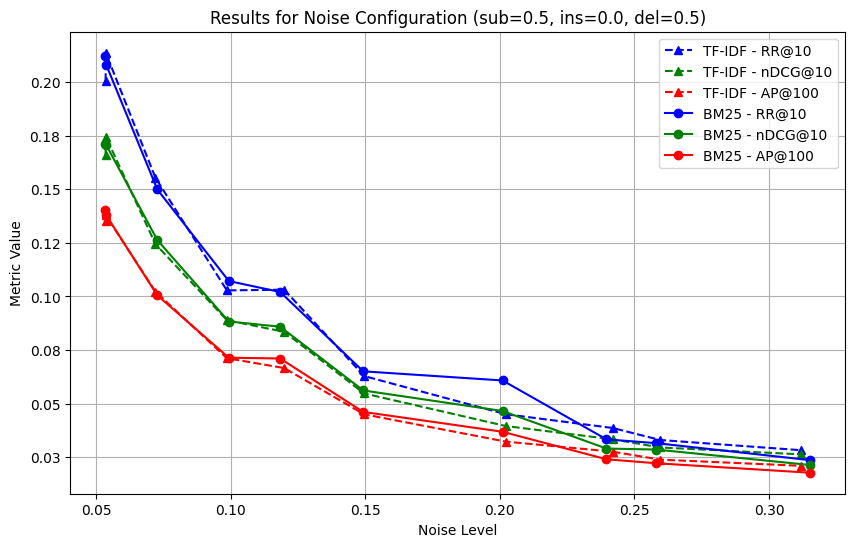

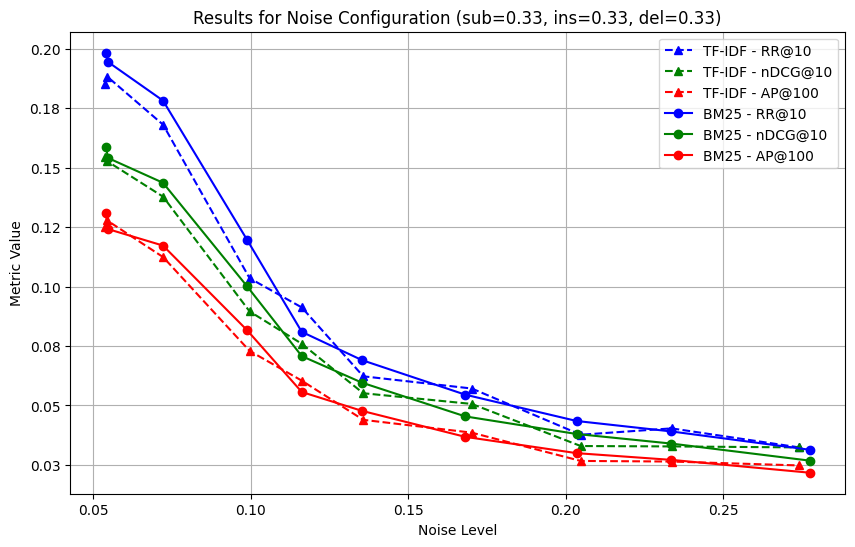

In [37]:
from matplotlib.ticker import FuncFormatter

# Define metrics and colors for each one
metrics = ['RR@10', 'nDCG@10', 'AP@100']
colors = ['b', 'g', 'r']

# Function to format y-axis values
def format_yaxis(value, _):
    return f"{value:.2f}"

# Loop through the data and plot for each noise configuration
for noise_config_data in results_batch_1:
    noise_config = noise_config_data['noise_config']
    results = noise_config_data['results']
    
    plt.figure(figsize=(10, 6))
    
    for model_data in results:
        model_name = model_data['model_name']
        model_results = model_data['results']
        
        for metric_index, metric in enumerate(metrics):
            noise_levels = [result['noise_level'] for result in model_results]
            metric_values = [result['results'][metric] for result in model_results]
            
            # Use triangles for TF-IDF and circles for BM25
            marker = '^' if model_name == 'TF-IDF' else 'o'
            line_style = '--' if model_name == 'TF-IDF' else '-'
            plt.plot(noise_levels, metric_values, label=f"{model_name} - {metric}", 
                     linestyle=line_style, color=colors[metric_index], marker=marker)
    
    # Set labels and title
    plt.xlabel('Noise Level')
    plt.ylabel('Metric Value')
    plt.title(f"Results for Noise Configuration (sub={noise_config['sub']}, ins={noise_config['ins']}, del={noise_config['del']})")
    plt.legend()
    plt.grid(True)
    
    # Apply y-axis formatter
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))
    
    plt.show()